# GridWorld Capture the Flag MVP Environment

In [1]:
from gridworld_ctf_mvp import GridworldCtf
from dqn_agent import DQNAgent
from dqn_network import DQNNetwork
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
import random
from matplotlib import pyplot as plt
from collections import deque
import copy
import time

# Check that current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# Check that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

False
False


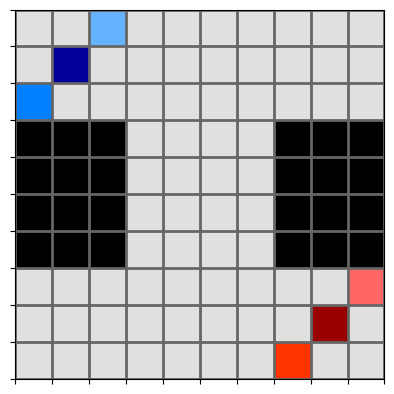

In [2]:
# instantiate environment
env = GridworldCtf(game_mode='random')
env.render()

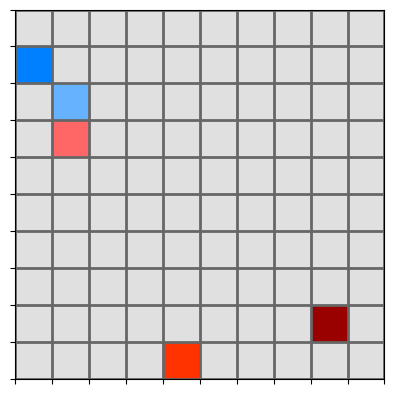

steps: 21
rewards: [-1, -1, -1, -1]
done: False
has flag: [0 0 1 0]


In [3]:
# basic example of mechanics
env = GridworldCtf(game_mode='static')

env.reset()
max_steps = 20
done = False
i = 0

while not done:
    actions = np.random.randint(4, size=4)
    _, rewards, done = env.step(actions)
    env.render()
    i += 1
    if i > max_steps:
        break
    
print(f"steps: {i}")
print(f"rewards: {rewards}")
print(f"done: {done}"), 
print(f"has flag: {env.has_flag}")

### DQN

### Multi-agent version

In [4]:
def add_noise(env_dims):
    """
    Add noise to stabilise training.
    """
    return np.random.rand(*env_dims)/100.0

def get_env_metadata(agent_idx, has_flag, device='cpu'):
    """
    Get agent turn and flag holder info.
    """
    agent_turn = np.array([0, 0, 0, 0], dtype=np.int8)
    agent_turn[agent_idx] = 1

    return torch.cat((torch.from_numpy(agent_turn), torch.from_numpy(has_flag))).reshape(1, 8).float().to(device)


In [5]:
# create environment
env = GridworldCtf(game_mode='static')
device = "cpu"

# configure agents
batch_size=32
gamma=0.9
lr=0.000025
epsilon=1.0
target_update_steps=1000
mem_size=20000
n_actions=4
use_softmax=True

agent_t1 = DQNAgent(q_network=DQNNetwork(name='dqn_t1', device=device),
                batch_size=batch_size,
                gamma=gamma,
                lr=lr,
                epsilon=epsilon,
                target_update_steps=target_update_steps,
                mem_size=mem_size,
                n_actions=n_actions,
                use_softmax=use_softmax)

agent_t2 = DQNAgent(q_network=DQNNetwork(name='dqn_t2', device=device),
                batch_size=batch_size,
                gamma=gamma,
                lr=lr,
                epsilon=epsilon,
                target_update_steps=target_update_steps,
                mem_size=mem_size,
                n_actions=n_actions,
                use_softmax=use_softmax)

# train agents
env_dims = (1, 1, 10, 10)
epochs = 2000
epsilon_decay = 0.999
epsilon_min = 0.1
losses = []
score_history = []
n_random_steps = 2000
max_steps = 1000
h = 0
step_count = 0
done_count = 0
team_1_wins = []
team_2_wins = []

for i in range(epochs):
    env.reset()

    curr_grid_state_ = env.grid.reshape(*env_dims) + add_noise(env_dims)
    curr_grid_state = torch.from_numpy(curr_grid_state_).float().to(device)

    done = False
    episode_step_count = 0
    score = 0
    while True: 
        step_count += 1
        episode_step_count += 1

        # collect actions for each agent
        actions =[]
        for agent_idx in env.dice_roll():
            curr_metadata_state = get_env_metadata(agent_idx, env.has_flag, device=device)
            if env.AGENT_TEAMS[agent_idx]==0:
                actions.append(agent_t1.choose_action(curr_grid_state, curr_metadata_state))
            else:
                actions.append(agent_t2.choose_action(curr_grid_state, curr_metadata_state))

        # step the environment
        new_grid_state, rewards, done = env.step(actions)
        new_grid_state_ = new_grid_state.reshape(*env_dims) + add_noise(env_dims)
        new_grid_state = torch.from_numpy(new_grid_state_).float().to(device)

        # increment score
        score += sum(rewards)

        # store each agent experiences
        for agent_idx in np.arange(4):
            new_metadata_state = get_env_metadata(agent_idx, env.has_flag, device=device)

            # append replay buffer
            if env.AGENT_TEAMS[agent_idx]==0:
                agent_t1.memory.append(
                                    ((curr_grid_state, curr_metadata_state), 
                                    actions[agent_idx], 
                                    rewards[agent_idx], 
                                    (new_grid_state, new_metadata_state), 
                                    done)
                                    )
            else:
                agent_t2.memory.append(
                                    ((curr_grid_state, curr_metadata_state), 
                                    actions[agent_idx], 
                                    rewards[agent_idx], 
                                    (new_grid_state, new_metadata_state), 
                                    done)
                                    )

        curr_grid_state = new_grid_state
        
        # learning
        if min(len(agent_t1.memory), len(agent_t1.memory)) > batch_size:
            loss_t1 = agent_t1.update_network(step_count)
            loss_t2 = agent_t2.update_network(step_count)
        else:
            loss_t1 = 0.0
            loss_t2 = 0.0

        # append metrics
        losses.append((loss_t1, loss_t2))  

        # termination
        if done or episode_step_count > max_steps:
            if done:
                done_count += 1
                team_1_wins.append((env.AGENT_TEAMS[env.winning_agent]==0.0) * 1)
                team_2_wins.append((env.AGENT_TEAMS[env.winning_agent]==1.0) * 1)
            break

    # decay epsilon
    epsilon_ = max(epsilon * epsilon_decay**i, epsilon_min)
    agent_t1.epsilon = epsilon_
    agent_t2.epsilon = epsilon_

    score_history.append(score)
    
    if i % 5 == 0:
        clear_output(wait=True)
        print(f'episode: {i} \ntotal step count: {step_count} \nepisode step count: {episode_step_count} \
              \nscore: {score} \naverage score: {np.mean(score_history[-100:])} \
              \nepsilon: {round(epsilon_, 4)} \ndone count: {done_count} \
              \nteam 1 wins: {team_1_wins} \nteam 2 wins: {team_2_wins}')

#losses = np.array(losses)
# save models
agent_t1.save_model()
agent_t2.save_model()

episode: 1780 
total step count: 195716 
episode step count: 50               
score: -99 
average score: -255.32               
epsilon: 0.1685 
done count: 1781               
team 1 wins: 609 
team 2 wins: 1172


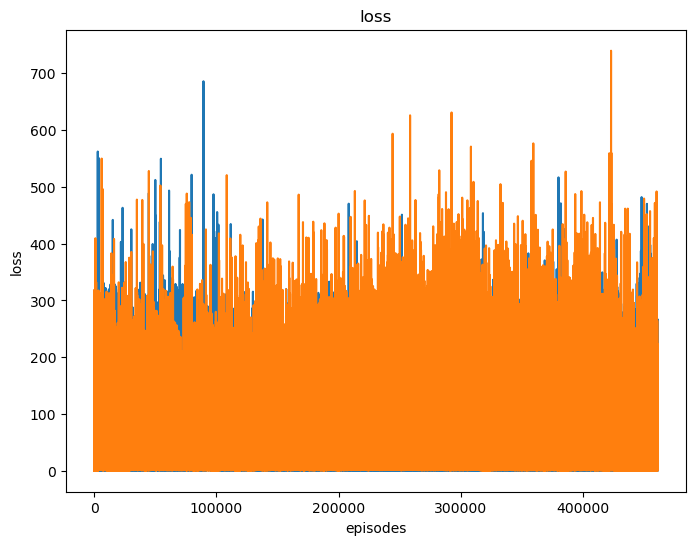

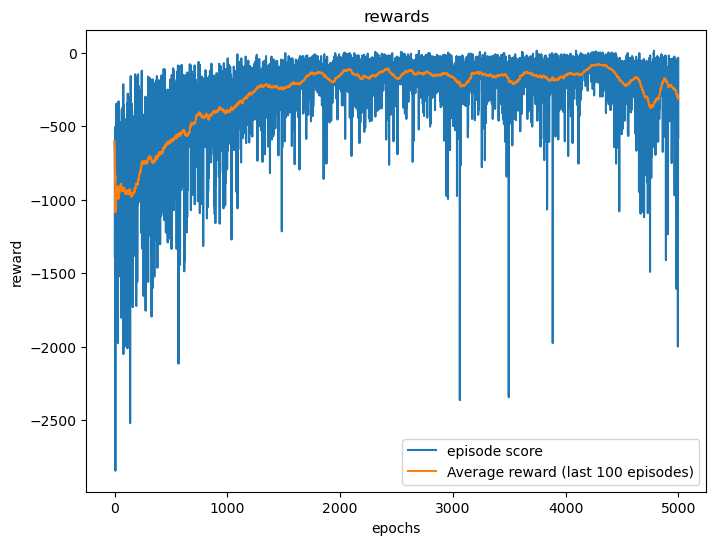

In [10]:
# Plot losses
plt.figure(figsize=(8, 6))
plt.title('loss')
plt.plot(losses)
plt.xlabel("episodes")
plt.ylabel("loss")

# Plot rewards
plt.figure(figsize=(8, 6))
plt.title('rewards')
plt.plot(score_history, label='episode score')
plt.plot([np.mean(score_history[::-1][i:i+100]) for i in range(len(score_history))][::-1], label='Average reward (last 100 episodes)')
plt.xlabel("epochs")
plt.ylabel("reward")
plt.legend()
plt.show()

In [14]:
def test_model(env, agent_t1, agent_t2, env_dims, display=True, max_moves=50):
    env.reset()

    curr_grid_state_ = env.grid.reshape(*env_dims) + add_noise(env_dims)
    curr_grid_state = torch.from_numpy(curr_grid_state_).float().to(device)

    done = False
    step_count = 0
    score = 0
    while not done: 
        step_count += 1

        # Collect actions for each agent
        actions =[]
        for agent_idx in env.dice_roll():
            curr_metadata_state = get_env_metadata(agent_idx, env.has_flag)
            if env.AGENT_TEAMS[agent_idx]==0:
                actions.append(agent_t1.choose_action(curr_grid_state, curr_metadata_state))
            else:
                actions.append(agent_t2.choose_action(curr_grid_state, curr_metadata_state))

        # Step the environment
        new_grid_state, rewards, done = env.step(actions)
        new_grid_state_ = new_grid_state.reshape(*env_dims) + add_noise(env_dims)
        new_grid_state = torch.from_numpy(new_grid_state_).float().to(device)

        # Increment score
        score += sum(rewards)

        if display:
            env.render(sleep_time=0.1)

        if done:
            if display:
                print(f"Game won! Final score: {score}")
       
        if (step_count > max_moves):
            if display:
                print(f"Move limit reached. Final score: {score}")
            break
    
    win = True if done else False
    return win

agent_t1.epsilon = agent_t2.epsilon = 0.0 
agent_t1.use_softmax = agent_t1.use_softmax = True 
env_dims = (1, 1, 10, 10)
test_model(env, agent_t1, agent_t2, env_dims, display=True, max_moves=1000)

TypeError: DQNAgent.softmax_policy() got multiple values for argument 'temp'